In [46]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Dataset

import zipfile

# Path to the ZIP file in Google Drive
zip_file_path = '/content/drive/My Drive/Colab Notebooks/data.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Huron_data')

In [60]:
# Import necessary libraries
import os
from model_config import *
from preprocess import *
from train import *
from utils import *
from inference import *
from torch.optim import AdamW
from loss import *
from data_visualization import *
import matplotlib.pyplot as plt

%matplotlib inline


# Define paths for the dataset for google colab
image_folder = os.path.join("/content/Huron_data/data/Huron_data/", "Sliced_Images")
mask_folder = os.path.join("/content/Huron_data/data/Huron_data/", "Sliced_masks")

# Ensure the dataset folders exist
assert os.path.exists(image_folder), "Image folder not found!"
assert os.path.exists(mask_folder), "Mask folder not found!"

In [5]:
######################################################################################
# Metrics improved by not removing black boarders and letting the encoder handle them.
# Details in preprocess.py
######################################################################################

# Specify the pre-trained model name
pretrained_model_name = "facebook/mask2former-swin-base-IN21k-ade-semantic"

# Load the image processor
image_processor = load_image_processor(
    pretrained_model_name=pretrained_model_name,
    do_rescale=True,
    do_normalize=False,  # Set to False for binary segmentation
    do_resize=True
)

# Load the Mask2Former model with binary segmentation setup
model = load_mask2former_model(
    pretrained_model_name=pretrained_model_name,
    num_labels=2,  # Binary segmentation (e.g., background and tissue)
    ignore_mismatched_sizes=True,
    freeze_encoder=True
)

# Print trainable layers for verification
print_trainable_layers(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/432M [00:00<?, ?B/s]

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.weight is frozen
model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.bias is frozen
model.pixel_level_module.encoder.embeddings.norm.weight is frozen
model.pixel_level_module.encoder.embeddings.norm.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.relative_position_bias_table is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.bias is frozen
model.pixel_level

In [6]:

# Create DataLoaders for training and validation
train_loader, val_loader,dataset, image_files, mask_files = create_dataloaders(
    image_folder=image_folder,
    mask_folder=mask_folder,
    image_processor=image_processor,
    batch_size=8, # Batch size 8 for balance between convergence speed and stability
    divide=1 # Size of the dataset 1 = FULL DATASET (reduce for faster training/testing)
)


# Verify DataLoaders are working correctly
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Print number of examples
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of validation examples: {len(val_loader.dataset)}")



Number of training batches: 1735
Number of validation batches: 434
Number of training examples: 13877
Number of validation examples: 3470


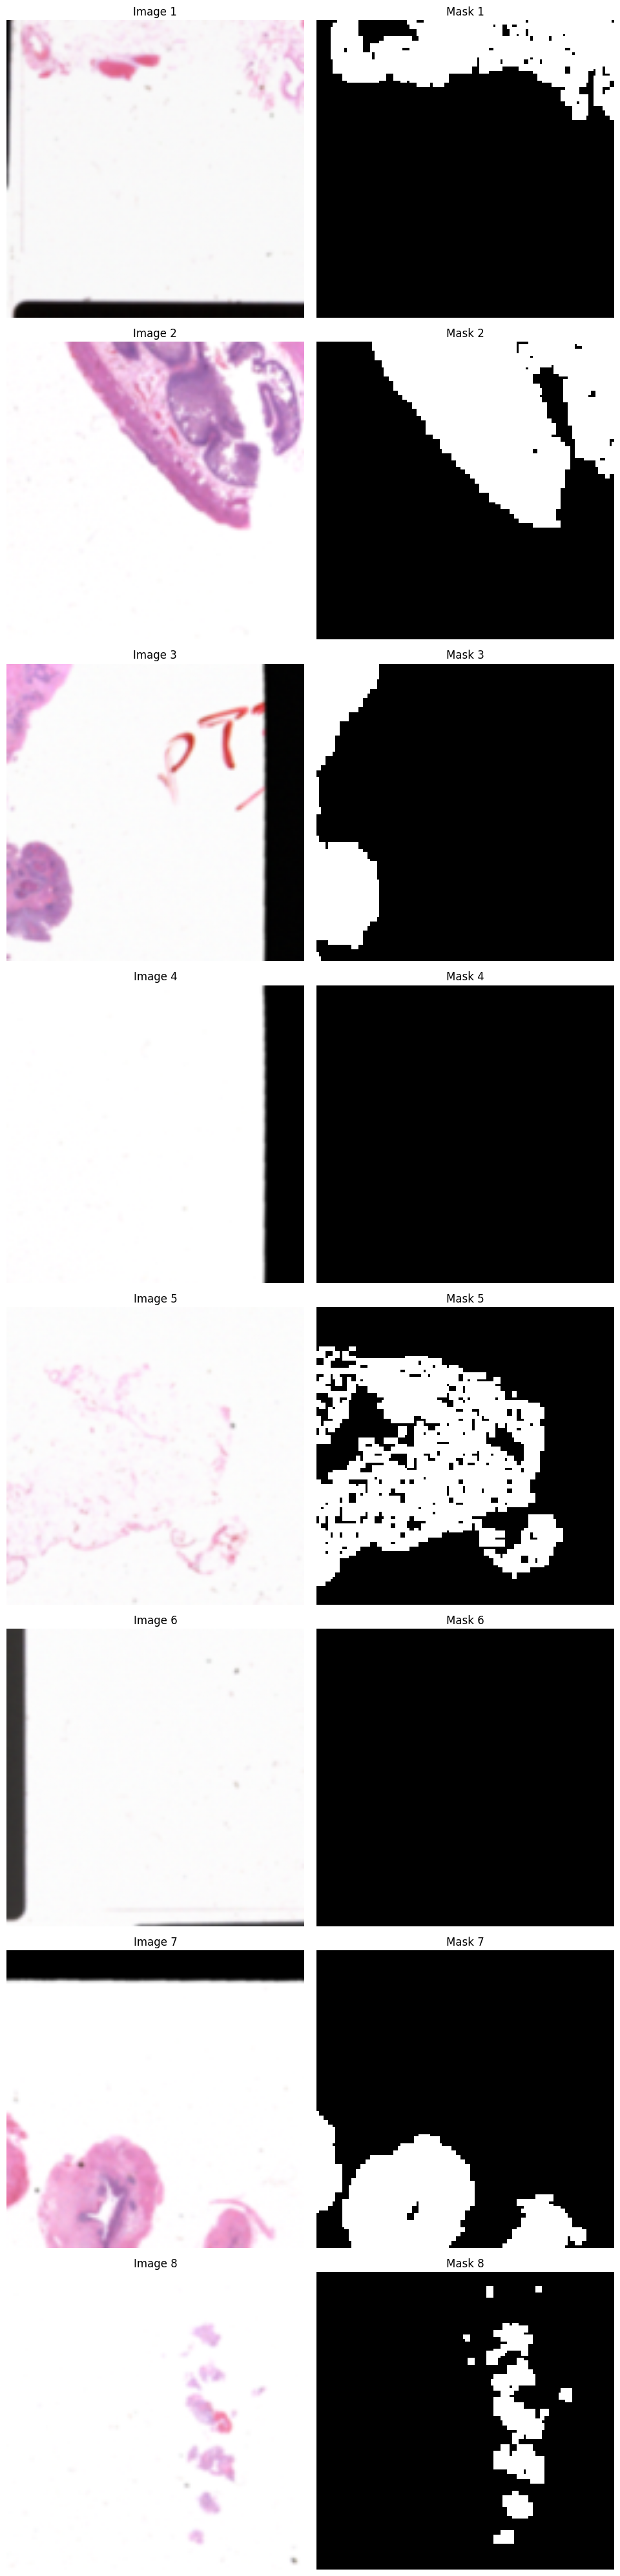

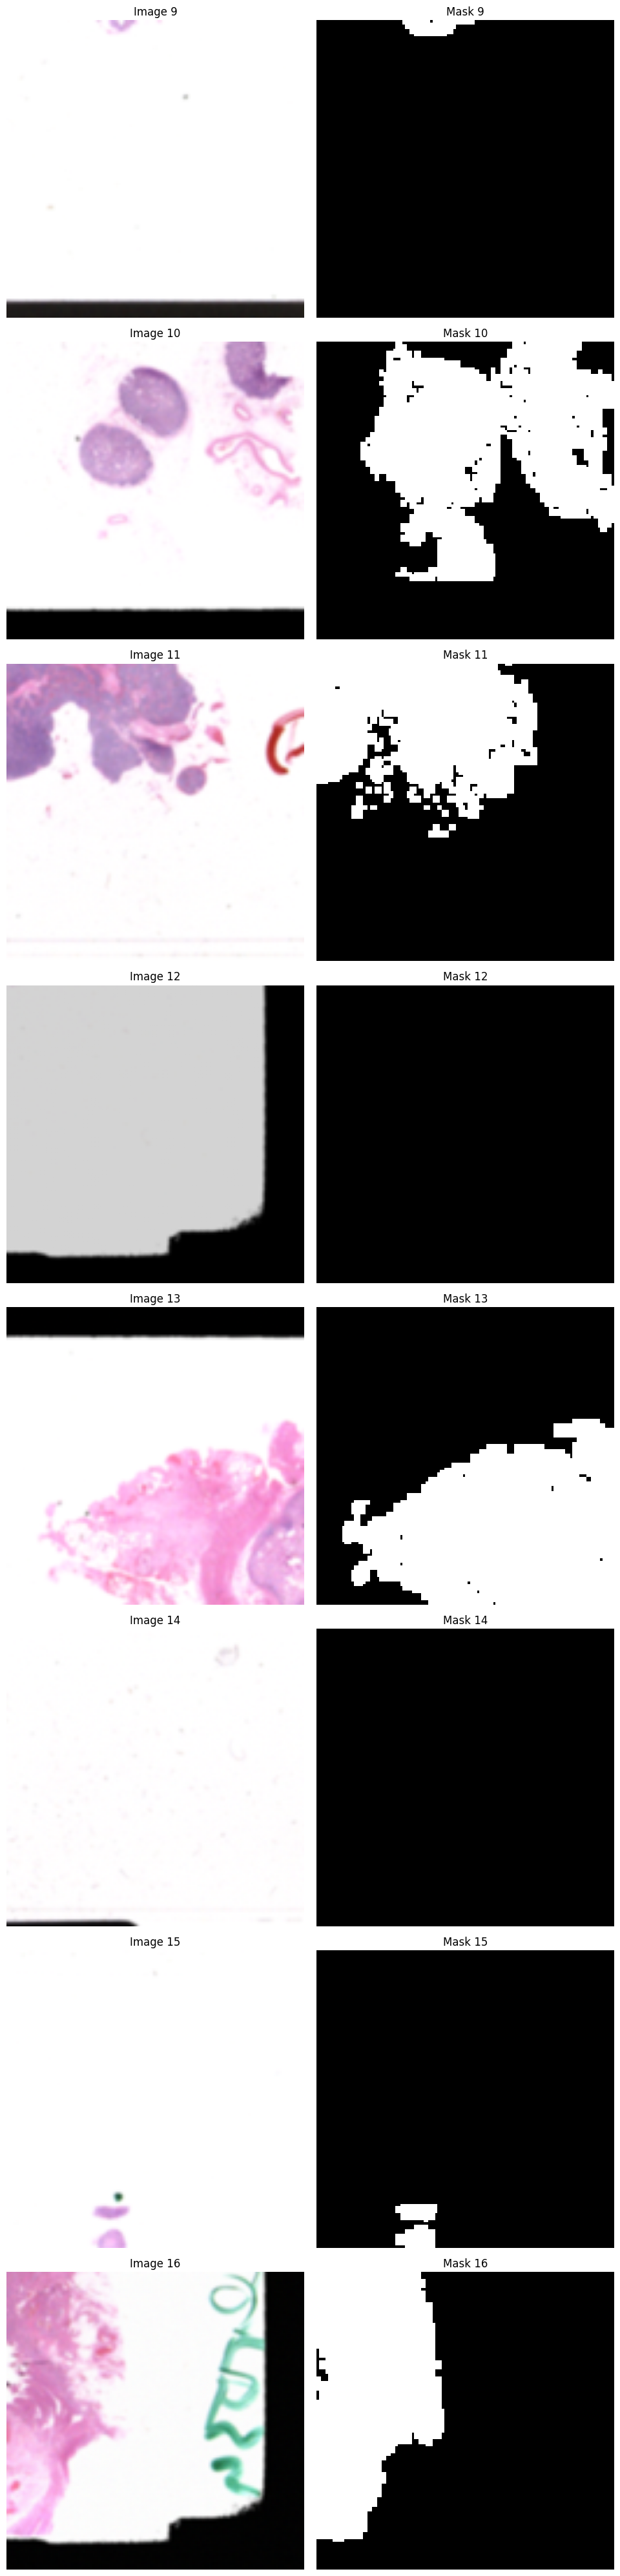

In [7]:
# Visualize batches from the train_loader
visualize_batch_from_loader(train_loader, 2) # Visualize 1 batch

In [8]:
# Verify alignment by visualizing masks, images, and ground truths
verify_data_alignment(dataset,image_files, num_samples=20)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
###########################################################################################################
#   Training the model on Best Parameters Found through Grid Seach (Refer to hyperparameter_tuning.ipynb) #
###########################################################################################################

###################################################################
# FULL MODEL TRAINING -  10 EPOCHS AND FULL DATA SET USING T4 GPU #
###################################################################

# Set the device - Note: without cuda, training on full dataset is VERY impractical
# On CPU, FUll dataset training will take 2 hours per epoch, while on GPU
# On GPU, Full dataset training will take ~5 to 40 minutes per epoch depending on the GPU and batch size
# A100 takes 5 -30 minutes per epoch, while T4 takes 30 - 40 minutes per epoch depending on batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device to be used
print(f"Device: {device}")

# Define the optimizer - learning rate must be 1e-4 to ensure convergence and reasonable epochs
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=0.0013032347157458826)  # Weight decay found through grid search

# Define the loss function - import ScaledDiceLoss() class from loss.py.
# This custom loss provides better metrics. Refer to pydoc in loss.py file for more details.
loss = ScaledDiceLoss(smooth=0.31038665868329945,  threshold_zero_loss=21) # Best parameters found through grid search

# Define the number of epochs to train
num_epochs = 15

# Train the model - updated to use the new train function with improved metrics and early stopping
# returns dictionary of training and validation metrics
train_metrics, val_metrics = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=loss,
    num_epochs=num_epochs,
    device=device
)






Device: cuda


Epoch [1/15] Training: 100%|██████████| 1735/1735 [23:47<00:00,  1.22it/s]


Epoch [1/15], Training Loss: 1.1731, Training IoU: 0.6738, Training Dice: 0.7587, Training Pixel Acc: 0.9495


Validation: 100%|██████████| 434/434 [04:38<00:00,  1.56it/s]


Epoch [1/15] Validation - Loss: 0.7193, IoU: 0.7700, Dice: 0.8440, Pixel acc: 0.9682



Epoch [2/15] Training: 100%|██████████| 1735/1735 [23:52<00:00,  1.21it/s]


Epoch [2/15], Training Loss: 0.8769, Training IoU: 0.7363, Training Dice: 0.8153, Training Pixel Acc: 0.9633


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [2/15] Validation - Loss: 0.7138, IoU: 0.7727, Dice: 0.8470, Pixel acc: 0.9687



Epoch [3/15] Training: 100%|██████████| 1735/1735 [23:48<00:00,  1.21it/s]


Epoch [3/15], Training Loss: 0.8000, Training IoU: 0.7547, Training Dice: 0.8306, Training Pixel Acc: 0.9662


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [3/15] Validation - Loss: 0.8046, IoU: 0.7510, Dice: 0.8311, Pixel acc: 0.9662



Epoch [4/15] Training: 100%|██████████| 1735/1735 [23:48<00:00,  1.21it/s]


Epoch [4/15], Training Loss: 0.7526, Training IoU: 0.7636, Training Dice: 0.8374, Training Pixel Acc: 0.9681


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [4/15] Validation - Loss: 0.7115, IoU: 0.7694, Dice: 0.8434, Pixel acc: 0.9695



Epoch [5/15] Training: 100%|██████████| 1735/1735 [23:46<00:00,  1.22it/s]


Epoch [5/15], Training Loss: 0.7291, Training IoU: 0.7717, Training Dice: 0.8442, Training Pixel Acc: 0.9689


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [5/15] Validation - Loss: 0.7449, IoU: 0.7719, Dice: 0.8479, Pixel acc: 0.9684



Epoch [6/15] Training: 100%|██████████| 1735/1735 [23:47<00:00,  1.22it/s]


Epoch [6/15], Training Loss: 0.7182, Training IoU: 0.7783, Training Dice: 0.8500, Training Pixel Acc: 0.9696


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [6/15] Validation - Loss: 0.6785, IoU: 0.7835, Dice: 0.8554, Pixel acc: 0.9705



Epoch [7/15] Training: 100%|██████████| 1735/1735 [23:47<00:00,  1.22it/s]


Epoch [7/15], Training Loss: 0.6875, Training IoU: 0.7844, Training Dice: 0.8553, Training Pixel Acc: 0.9704


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [7/15] Validation - Loss: 0.7121, IoU: 0.7716, Dice: 0.8465, Pixel acc: 0.9697



Epoch [8/15] Training: 100%|██████████| 1735/1735 [23:51<00:00,  1.21it/s]


Epoch [8/15], Training Loss: 0.6845, Training IoU: 0.7865, Training Dice: 0.8569, Training Pixel Acc: 0.9706


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [8/15] Validation - Loss: 0.7388, IoU: 0.7658, Dice: 0.8429, Pixel acc: 0.9688



Epoch [9/15] Training: 100%|██████████| 1735/1735 [23:48<00:00,  1.21it/s]


Epoch [9/15], Training Loss: 0.6754, Training IoU: 0.7882, Training Dice: 0.8580, Training Pixel Acc: 0.9710


Validation: 100%|██████████| 434/434 [04:38<00:00,  1.56it/s]


Epoch [9/15] Validation - Loss: 0.7229, IoU: 0.7690, Dice: 0.8458, Pixel acc: 0.9693



Epoch [10/15] Training: 100%|██████████| 1735/1735 [23:46<00:00,  1.22it/s]


Epoch [10/15], Training Loss: 0.6643, Training IoU: 0.7912, Training Dice: 0.8609, Training Pixel Acc: 0.9712


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [10/15] Validation - Loss: 0.6973, IoU: 0.7788, Dice: 0.8520, Pixel acc: 0.9702



Epoch [11/15] Training: 100%|██████████| 1735/1735 [23:46<00:00,  1.22it/s]


Epoch [11/15], Training Loss: 0.6637, Training IoU: 0.7915, Training Dice: 0.8610, Training Pixel Acc: 0.9713


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [11/15] Validation - Loss: 0.7908, IoU: 0.7642, Dice: 0.8408, Pixel acc: 0.9671



Epoch [12/15] Training: 100%|██████████| 1735/1735 [23:46<00:00,  1.22it/s]


Epoch [12/15], Training Loss: 0.6552, Training IoU: 0.7933, Training Dice: 0.8624, Training Pixel Acc: 0.9717


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [12/15] Validation - Loss: 0.6611, IoU: 0.7912, Dice: 0.8617, Pixel acc: 0.9713



Epoch [13/15] Training: 100%|██████████| 1735/1735 [23:45<00:00,  1.22it/s]


Epoch [13/15], Training Loss: 0.6617, Training IoU: 0.7932, Training Dice: 0.8621, Training Pixel Acc: 0.9717


Validation: 100%|██████████| 434/434 [04:37<00:00,  1.56it/s]


Epoch [13/15] Validation - Loss: 0.7916, IoU: 0.7626, Dice: 0.8392, Pixel acc: 0.9670



Epoch [14/15] Training: 100%|██████████| 1735/1735 [23:49<00:00,  1.21it/s]


Epoch [14/15], Training Loss: 0.6512, Training IoU: 0.7950, Training Dice: 0.8636, Training Pixel Acc: 0.9718


Validation: 100%|██████████| 434/434 [04:40<00:00,  1.55it/s]


Epoch [14/15] Validation - Loss: 0.7494, IoU: 0.7676, Dice: 0.8436, Pixel acc: 0.9686



Epoch [15/15] Training: 100%|██████████| 1735/1735 [23:59<00:00,  1.21it/s]


Epoch [15/15], Training Loss: 0.6393, Training IoU: 0.7964, Training Dice: 0.8647, Training Pixel Acc: 0.9721


Validation: 100%|██████████| 434/434 [04:41<00:00,  1.54it/s]

Epoch [15/15] Validation - Loss: 0.7493, IoU: 0.7659, Dice: 0.8410, Pixel acc: 0.9685



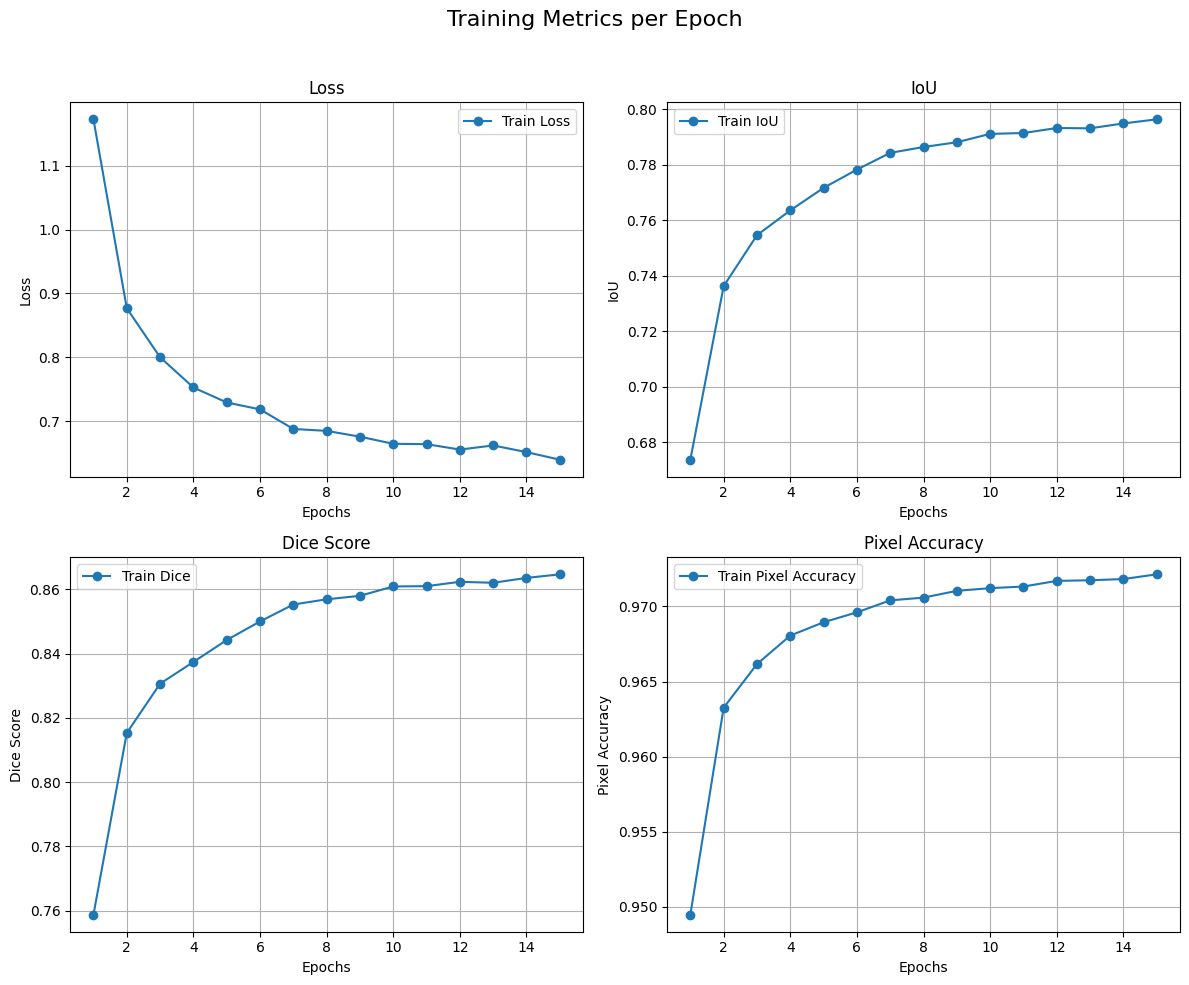

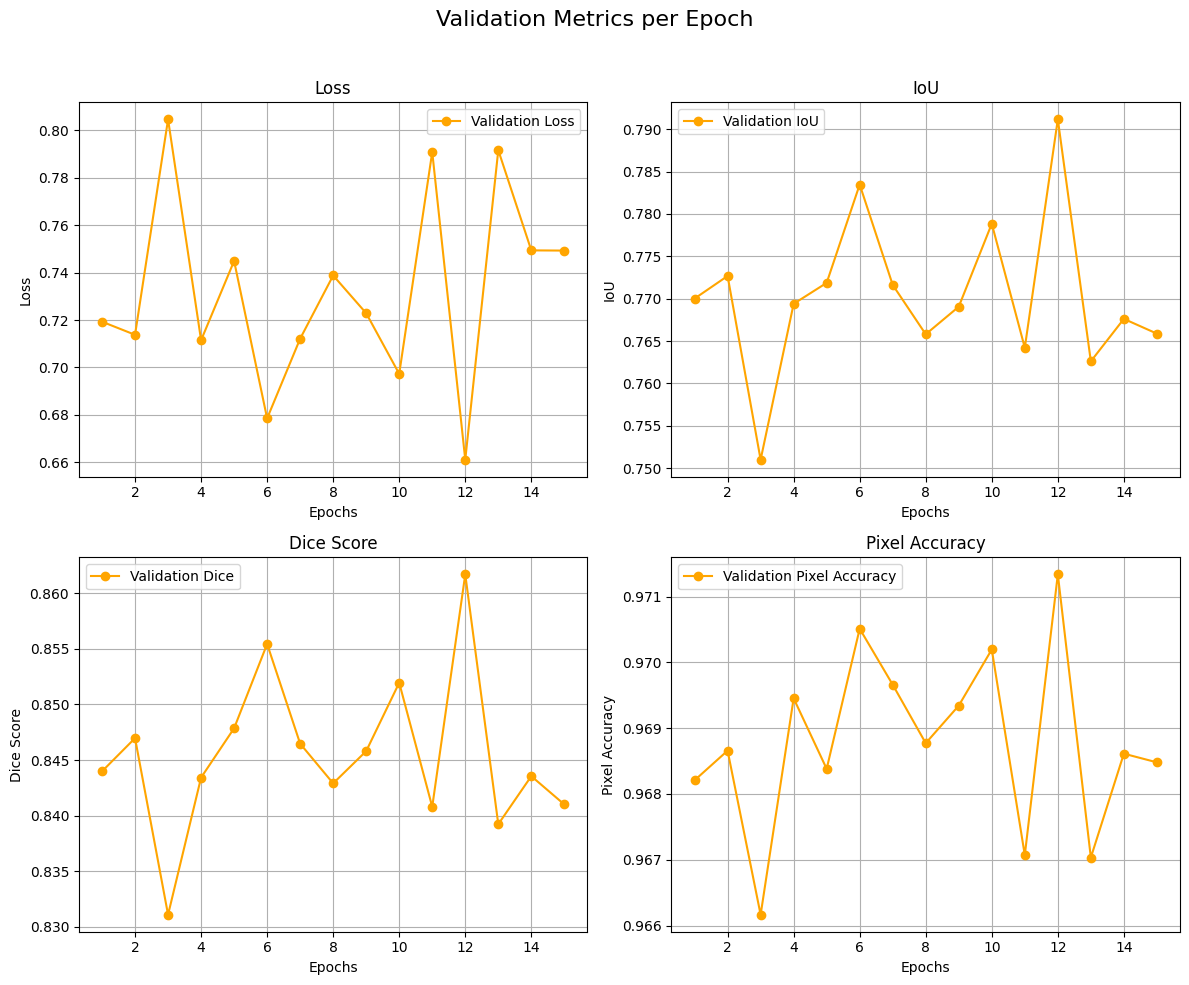

In [63]:


# Call functions from data_visualization.py to visualize training and validation metrics
visualize_training_metrics(train_metrics)
visualize_validation_metrics(val_metrics)


In [13]:
# Save the model and Load the model for inferencing

# Specify the path to save the model
model_path =  os.getcwd() + "/huron/models/final_model_epoch15_batch8"


# Use utils.py to save the model
save_model_and_processor(model=model, image_processor=image_processor, save_dir=model_path)





Model and image processor saved to /content/huron/models/final_model_epoch15_batch8


In [14]:
# Specify the path to save the model
model_path =  os.getcwd() + "/huron/models/final_model_epoch15_batch8"

# Load the model and processor
model_test, image_processor_test = load_model_and_processor(model_path)


Model and image processor loaded from /content/huron/models/final_model_epoch15_batch8


In [16]:


# Inference on the test set using inference.py

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device to be used
print(f"Device: {device}")

# send model to device
model_test.to(device)

# Call the inference function
infer_and_display(
    model=model_test,
    image_processor=image_processor_test,
    dataloader=val_loader,
    device=device,
    num_samples=100,
    target_size=(256,256)
)




Output hidden; open in https://colab.research.google.com to view.